In [ ]:
!pip install -q kagglehub
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abjayani","key":"0cf43ba244b2fca7611855032afb5045"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [45]:
import kagglehub
import os

path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flickr8k


In [46]:
import pandas as pd

captions_file_path = os.path.join(path, 'captions.txt')
images_folder_path = os.path.join(path, 'Images')

captions_df = pd.read_csv(captions_file_path)
captions_df.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [54]:
# Pick 1000 unique images
unique_images = captions_df['image'].unique()
unique_images = unique_images[:1000]
#divided into test and train
train_images = unique_images[:900]
test_images = unique_images[900:1000]
print(f"unique_images: {len(unique_images)}")
print(f"Train Images: {len(train_images)}")
print(f"Test Images: {len(test_images)}")

unique_images: 1000
Train Images: 900
Test Images: 100


In [55]:
# Filter captions dataframe
captions_df = captions_df[captions_df['image'].isin(unique_images)].reset_index(drop=True)

print(f"Selected {len(unique_images)} images")
captions_df.shape
#har ek image k pass 5 captions hai toh 550*5=2750
# captions_df.head()

Selected 1000 images


(5000, 2)

In [56]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [57]:
def show_img_with_captions(i,image_id):
  img_path = os.path.join(images_folder_path, image_id)
  img = mpimg.imread(img_path)
  captions = captions_df[captions_df['image'] == sample_img]['caption'].values
  print("Image Number: ",i+1,"\n")
  plt.imshow(img)
  plt.axis('off')
  plt.show()
  print("Captions:")
  for j,cap in enumerate(captions):
      print(j+1,cap)
  print()

Image Number:  1 



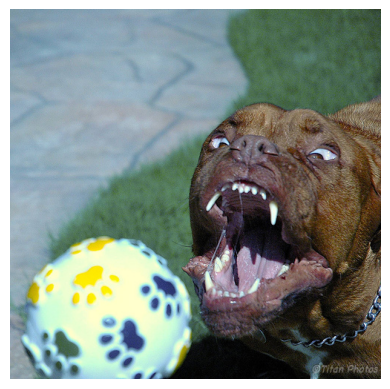

Captions:
1 A dog trying to catch a ball .
2 A dog with fangs revealed is about to bite a ball with paw prints on it .
3 A intense looking dog is about to grab a ball in mid bounce .
4 Brown dog trying to bite a white ball with yellow , green and blue puppy toes
5 The brown dog is about to bite a paw printed ball .

Image Number:  2 



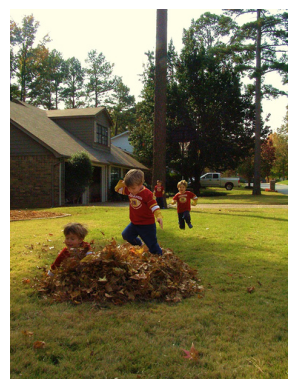

Captions:
1 Children in red shirts play in the leaves .
2 Four boys in red are playing with fallen leaves .
3 Several children leaping into a pile of leaves on the ground .
4 Small children are playing in a pile of dead leaves .
5 Three kids jumping in leaves .

Image Number:  3 



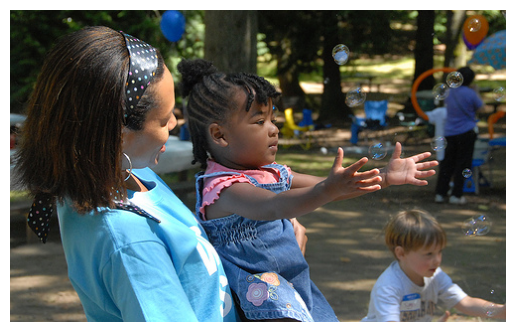

Captions:
1 A lady holds a little girl who is trying to catch bubbles .
2 A woman is holding a little girl who is trying to catch bubbles .
3 A woman with holding a young girl playing with bubbles at a picnic .
4 A young woman in a blue shirt stands , holding a young girl in a denim dress .
5 There is a woman holding her baby daughter while the daughter claps .

Image Number:  4 



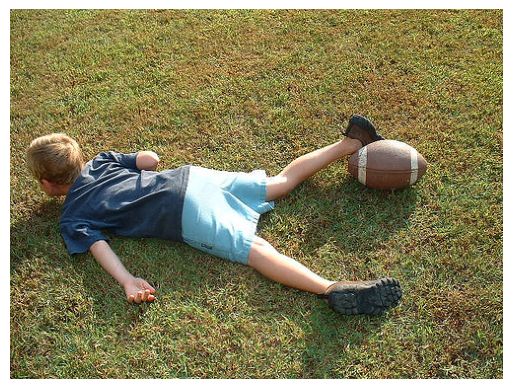

Captions:
1 A boy in blue with a football sprawls in the grass .
2 A boy laying on the grass face down with a football at his feet .
3 Boy is lying face down in the grass with his foot on a football .
4 The boy is on the ground next to the football .
5 The little boy fell face first into the grass while playing football .

Image Number:  5 



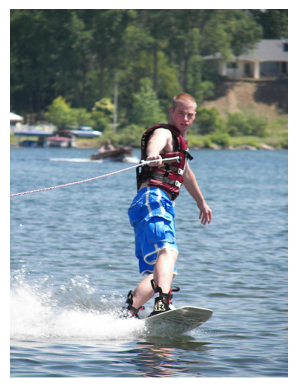

Captions:
1 A guy waterskiing behind a boat .
2 a man wakeboards on a lake .
3 A young man is wakeboarding on a body of water .
4 Blond boy waterskiing .
5 The boy is wakeboarding on the lake .



In [58]:
sample_images = random.sample(list(train_images), 5)

for i,sample_img in enumerate(sample_images):
  show_img_with_captions(i,sample_img)

In [59]:
import numpy as np
import os
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tqdm import tqdm  # ye progress bar show karne k liye hai so that hame pta chalta rahe ki kitna time or legega

In [60]:
# Load EfficientNetB0 pre-trained model
efficientnet = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')

In [61]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [62]:
features = {}

for img_name in tqdm(unique_images, desc="Extracting image features"):
    img_path = os.path.join(images_folder_path, img_name)
    img_array = preprocess_image(img_path)
    feature = efficientnet.predict(img_array, verbose=0)
    features[img_name] = feature

Extracting image features: 100%|██████████| 1000/1000 [04:19<00:00,  3.85it/s]


In [63]:
import re

def clean_caption(caption):
    caption = caption.lower()
    caption = re.sub(r"[^a-z]+", " ", caption)
    caption = caption.strip()
    caption = '<startseq> ' + caption + ' <endseq>'
    return caption

captions_df['caption'] = captions_df['caption'].apply(clean_caption)
captions_df.head()


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  <startseq> a child in a pink dress is climbing...  
1  <startseq> a girl going into a wooden building...  
2  <startseq> a little girl climbing into a woode...  
3  <startseq> a little girl climbing the stairs t...  
4  <startseq> a little girl in a pink dress going...

In [64]:
from tensorflow.keras.preprocessing.text import Tokenizer

all_captions = list(captions_df['caption'])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary Size: {vocab_size}")


Vocabulary Size: 3214


In [65]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Determine the longest caption
max_caption_len = max(len(c.split()) for c in all_captions)
print(f"Max Caption Length: {max_caption_len}")

def generate_training_sequences(tokenizer, max_len, caption_data, image_features):
    visual_input, text_input, output_word = [], [], []

    for _, entry in caption_data.iterrows():
        full_caption = entry['caption']
        image_id = entry['image']
        img_feature = image_features[image_id][0]

        sequence = tokenizer.texts_to_sequences([full_caption])[0]

        for j in range(1, len(sequence)):
            partial_seq = sequence[:j]
            target_word = sequence[j]

            padded_seq = pad_sequences([partial_seq], maxlen=max_len)[0]
            encoded_output = tf.keras.utils.to_categorical([target_word], num_classes=vocab_size)[0]

            visual_input.append(img_feature)
            text_input.append(padded_seq)
            output_word.append(encoded_output)

    return np.array(visual_input), np.array(text_input), np.array(output_word)

X1, X2, y = generate_training_sequences(tokenizer, max_caption_len, captions_df, features)
print(f"Shapes: {X1.shape}, {X2.shape}, {y.shape}")

Max Caption Length: 35
Shapes: (60167, 1280), (60167, 35), (60167, 3214)


In [66]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model

# Image feature extractor model
inputs1 = Input(shape=(1280,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence model
inputs2 = Input(shape=(max_caption_len,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge it
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 1280)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 35, 256)   │    822,784 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 1280)      │          0 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 35, 256)   │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 35)        │          0 │ input_layer_6[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    327,936 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ dropout_4[0][0],  │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dense_4[0][0],    │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │     65,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 3214)      │    825,998 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,567,822 (9.80 MB)

 Trainable params: 2,567,822 (9.80 MB)

 Non-trainable params: 0 (0.00 B)

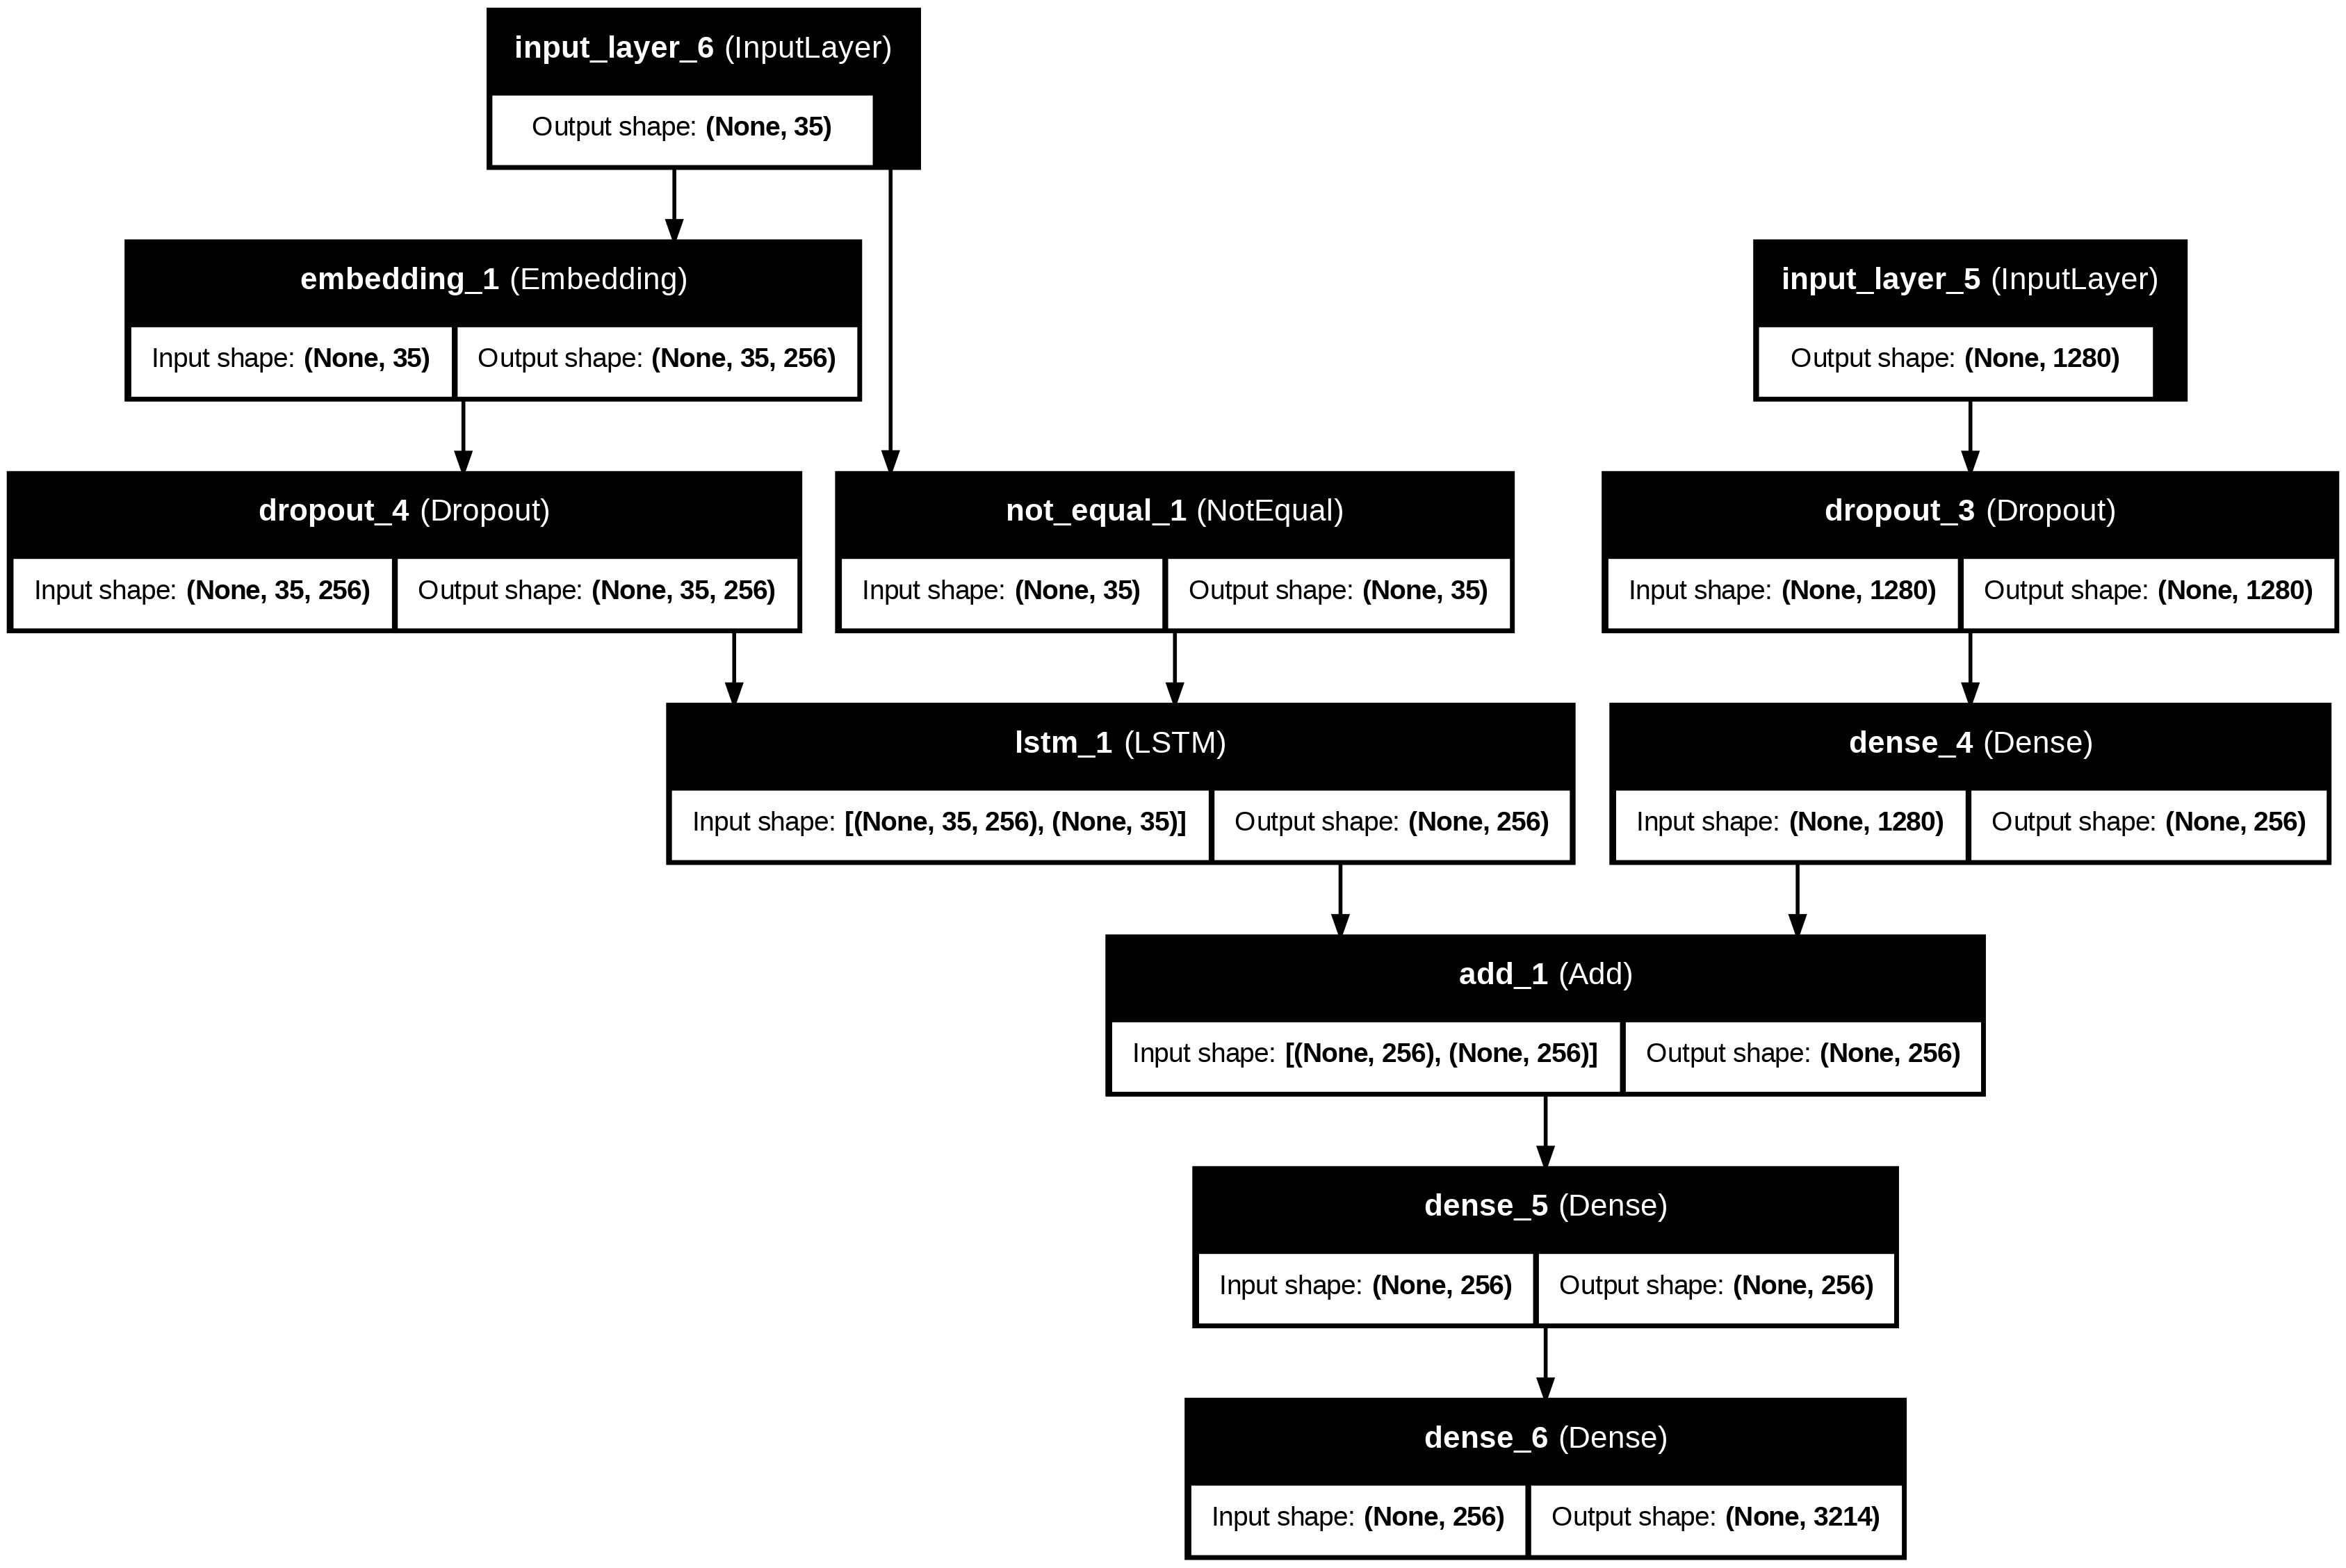

In [67]:
from tensorflow.keras.utils import plot_model

# Visualize the model
plot_model(model, show_shapes=True, show_layer_names=True)

In [68]:
#training our Model
model.fit([X1, X2], y, epochs=10, batch_size=64, validation_split=0.1)

Epoch 1/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 257s 300ms/step - loss: 5.1236 - val_loss: 4.1036
Epoch 2/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 262s 300ms/step - loss: 3.5804 - val_loss: 3.9778
Epoch 3/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 253s 299ms/step - loss: 3.0601 - val_loss: 3.9676
Epoch 4/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 261s 298ms/step - loss: 2.6598 - val_loss: 4.1041
Epoch 5/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 259s 294ms/step - loss: 2.3220 - val_loss: 4.2133
Epoch 6/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 264s 297ms/step - loss: 2.0480 - val_loss: 4.4177
Epoch 7/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 255s 301ms/step - loss: 1.8539 - val_loss: 4.5858
Epoch 8/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 254s 300ms/step - loss: 1.6776 - val_loss: 4.7724
Epoch 9/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 260s 297ms/step - loss: 1.5261 - val_loss: 4.9257
Epoch 10/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 261s 308ms/step - loss: 1.4156 - val_loss: 5.0776


In [71]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [73]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [74]:
def generate_caption(model, tokenizer, photo, max_length):
    in_text = 'startseq'  # Start the caption sequence

    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]  # Convert text to sequence
        sequence = pad_sequences([sequence], maxlen=max_length)  # Pad sequence to max length

        # Predict next word
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)  # Get word with highest probability

        word = tokenizer.index_word.get(yhat, None)  # Get word from index

        if word is None:  # If no word is found, break
            break
        in_text += ' ' + word  # Append predicted word to caption

        if word == 'endseq':  # Stop if 'endseq' is predicted
            break

    return in_text

In [83]:
# Combine test images and trained images
combined_images =list(unique_images)

# Select 5 random images from the combined list
random_test_imgs = random.sample(combined_images, 5)

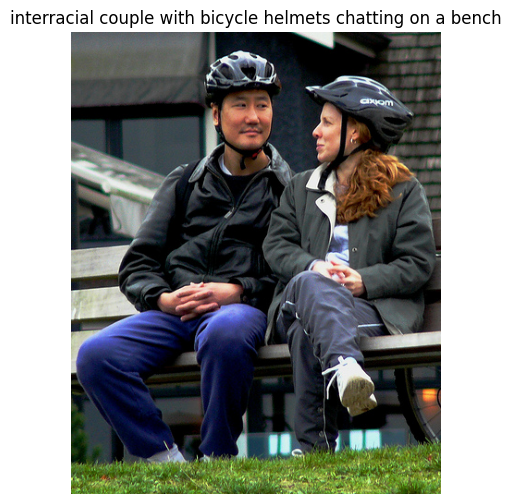

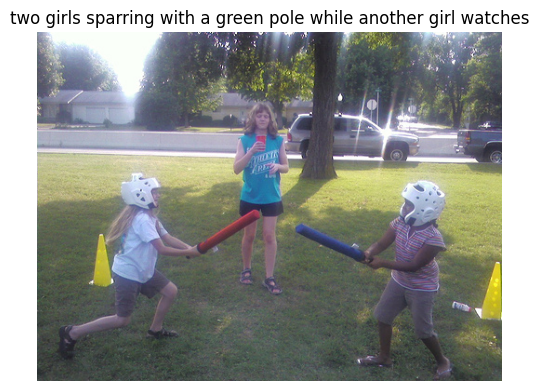

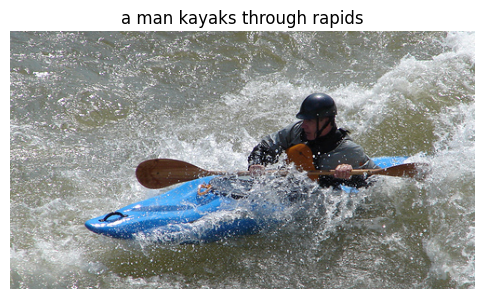

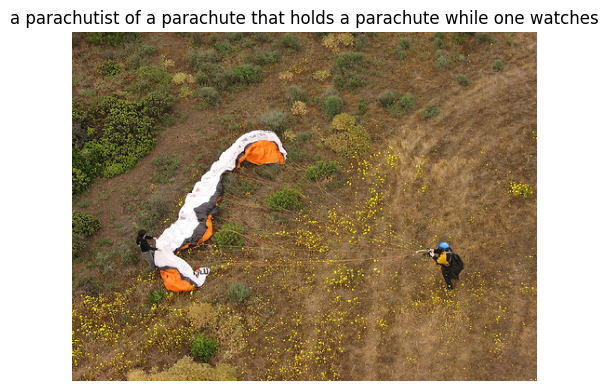

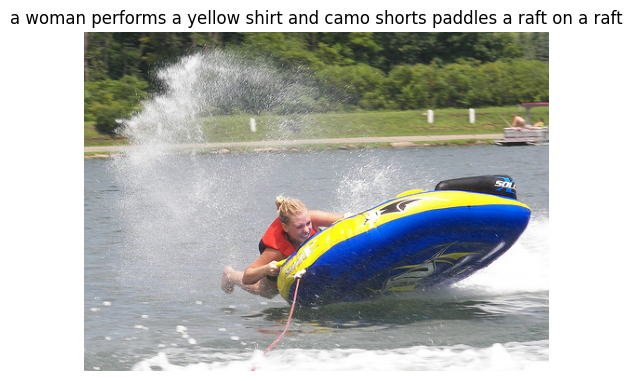

In [84]:
# Loop through each random test image
for img_name in random_test_imgs:
    img_path = os.path.join(images_folder_path, img_name)  # Get image path

    # Preprocess the image and extract feature
    img_array = preprocess_image(img_path)
    feature = efficientnet.predict(img_array, verbose=0)  # Get feature from the model

    # Generate caption for the image
    caption = generate_caption(model, tokenizer, feature, max_caption_len)

    # Clean up the generated caption
    caption = caption.replace('startseq', '').replace('endseq', '').strip()

    # Display the image and its caption
    plt.figure(figsize=(6, 6))
    plt.imshow(mpimg.imread(img_path))
    plt.axis('off')
    plt.title(caption, fontsize=12)
    plt.show()
